## Project : Cell image segmentation projects

Contact: Elena Casiraghi (University Milano elena.casiraghi@unimi.it)

Cell segmentation is usually the first step for downstream single-cell analysis in microscopy image-based biology and biomedical research. Deep learning has been widely used for cell-image segmentation.
The CellSeg competition aims to benchmark cell segmentation methods that could be applied to various microscopy images across multiple imaging platforms and tissue types for cell Segmentation. The  Dataset challenge organizers provide both labeled images and unlabeled ones.
The “2018 Data Science Bowl” Kaggle competition provides cell images and their masks for training cell/nuclei segmentation models.

In 2022 another [Cell Segmentation challenge was proposed at Neurips](https://neurips22-cellseg.grand-challenge.org/).
For interested readers, the competition proceeding has been published on [PMLR](https://proceedings.mlr.press/v212/)

### Project Description

In the field of (bio-medical) image processing, segmentation of images is typically performed via U-Nets [1,2].

A U-Net consists of an encoder - a series of convolution and pooling layers which reduce the spatial resolution of the input, followed by a decoder - a series of transposed convolution and upsampling layers which increase the spatial resolution of the input. The encoder and decoder are connected by a bottleneck layer which is responsible for reducing the number of channels in the input.
The key innovation of U-Net is the addition of skip connections that connect the contracting path to the corresponding layers in the expanding path, allowing the network to recover fine-grained details lost during downsampling.

<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png' width="400"/>


At this [link](https://rpubs.com/eR_ic/unet), you find an R implementation of basic U-Nets. At this [link](https://github.com/zhixuhao/unet), you find a Keras implementation of UNets.  
Other implementations of more advanced UNets are also made available in [2] at these links: [UNet++](https://github.com/MrGiovanni/UNetPlusPlus)
and by the CellSeg organizers as baseline models: [https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/](https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/)


### Project aim

The aim of the project is to download the *gray-level* (.tiff or .tif files) cell images from the [CellSeg](https://neurips22-cellseg.grand-challenge.org/dataset/) competition and assess the performance of an UNet or any other Deep model for cell segmentation.
We suggest using gray-level images to obtain a model that is better specified on a sub class of images.

Students are not restricted to use UNets but may other model is wellcome; e.g., even transformer based model in the [leaderboard](https://neurips22-cellseg.grand-challenge.org/evaluation/testing/leaderboard/) may be tested.
Students are free to choose any model, as long as they are able to explain their rationale, architecture, strengths and weaknesses.



### References

[1] Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab, N., Hornegger, J., Wells, W., Frangi, A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science(), vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

[2] Long, F. Microscopy cell nuclei segmentation with enhanced U-Net. BMC Bioinformatics 21, 8 (2020). https://doi.org/10.1186/s12859-019-3332-1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 1: Install and Import Necessary Libraries
# ===============================================
!pip install -q tifffile scikit-image
# Install the imagecodecs package to handle LZW compressed TIFF files
!pip install -q imagecodecs

import os
import numpy as np
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import warnings
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.layers import RandomFlip, RandomRotation

print("All libraries imported successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 21.6 MB/s eta 0:00:00
All libraries imported successfully.


In [ ]:
BASE_PATH = '/content/drive/MyDrive/CellSegmentation/NeurIPS22-CellSeg/'

TRAIN_IMG_DIR = os.path.join(BASE_PATH, 'Training/images/')
TRAIN_LBL_DIR = os.path.join(BASE_PATH, 'Training/labels/')

# We will use the 'Tuning' folder as our validation set
VAL_IMG_DIR = os.path.join(BASE_PATH, 'Tuning/images/')
VAL_LBL_DIR = os.path.join(BASE_PATH, 'Tuning/labels/')

# Check if the paths exist
if os.path.exists(TRAIN_IMG_DIR) and os.path.exists(VAL_IMG_DIR):
    print("\nDataset paths seem correct.")
    print(f"Training images found: {len(os.listdir(TRAIN_IMG_DIR))}")
    print(f"Validation images found: {len(os.listdir(VAL_IMG_DIR))}")
else:
    print("\n[ERROR] Dataset paths not found. Please check the BASE_PATH variable.")



# Define Constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

def load_and_preprocess_data(image_dir, label_dir):
    """
    Loads images and labels from the specified directories,
    handles mismatched extensions, resizes, and normalizes them.
    """
    image_filenames = sorted(os.listdir(image_dir))

    X_data = []
    Y_data = []

    print(f"Loading data from: {image_dir}")
    for i, filename in enumerate(image_filenames):
        if i % 50 == 0:
            print(f"  Processing image {i}/{len(image_filenames)}")

        # --- Find matching label ---
        base_name = os.path.splitext(filename)[0] # e.g., 'cell_00001'

        # Try to find the label with common mask extensions
        possible_label_paths = [
            os.path.join(label_dir, base_name +  '_label.tif'),
            os.path.join(label_dir, base_name + '_label.tiff'),
            os.path.join(label_dir, base_name + '_label.png')
        ]

        lbl_path = None
        for path in possible_label_paths:
            if os.path.exists(path):
                lbl_path = path
                break

        # If no label is found after checking, skip this image
        if lbl_path is None:
            warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
            continue

        # --- Load and process the image ---
        img_path = os.path.join(image_dir, filename)
        try:
            img = imread(img_path)
            # Ensure image is 2D (grayscale)
            if len(img.shape) > 2 and img.shape[2] > 1:
                img = img[:, :, 0]
            elif len(img.shape) == 2: # Already grayscale
                pass
            else: # Single channel image with shape (H, W, 1)
                img = img.squeeze()

            img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            X_data.append(img_resized)

            # --- Load and process the corresponding label ---
            label = imread(lbl_path)
            if len(label.shape) > 2 and label.shape[2] > 1: # Ensure label is 2D
                label = label[:,:,0]
            label_resized = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            Y_data.append(label_resized)

        except Exception as e:
            warnings.warn(f"[ERROR] Could not process file {filename} due to: {e}. Skipping.")

    # Convert lists to numpy arrays
    X_data = np.array(X_data, dtype=np.uint8)
    # Ensure masks are boolean (0 or 1). Anything > 0 becomes 1.
    Y_data = (np.array(Y_data) > 0).astype(np.bool_)

    # Add the channel dimension for the model
    X_data = np.expand_dims(X_data, axis=-1)
    Y_data = np.expand_dims(Y_data, axis=-1)

    return X_data, Y_data

# Load the training and validation data using our corrected function
X_train, Y_train = load_and_preprocess_data(TRAIN_IMG_DIR, TRAIN_LBL_DIR)
X_val, Y_val = load_and_preprocess_data(VAL_IMG_DIR, VAL_LBL_DIR)

print("\nData loading and preprocessing complete.")
if len(X_train) > 0 and len(X_val) > 0:
    print(f"Total training samples loaded: {len(X_train)}")
    print(f"Training data shape (X_train): {X_train.shape}")
    print(f"Training labels shape (Y_train): {Y_train.shape}")
    print(f"\nTotal validation samples loaded: {len(X_val)}")
    print(f"Validation data shape (X_val): {X_val.shape}")
    print(f"Validation labels shape (Y_val): {Y_val.shape}")
else:
    print("\n[ERROR] No data was loaded. Please check your file paths and names.")


Dataset paths seem correct.
Training images found: 1000
Validation images found: 86
Loading data from: /content/drive/MyDrive/CellSegmentation/NeurIPS22-CellSeg/Training/images/
  Processing image 0/1000
  Processing image 50/1000


/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00063.bmp. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00073.bmp. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00074.bmp. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00077.bmp. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00079.bmp. Skipping.
  warnings.warn(f"[WARNING] No matchi

  Processing image 100/1000
  Processing image 150/1000
  Processing image 200/1000
  Processing image 250/1000
  Processing image 300/1000
  Processing image 350/1000
  Processing image 400/1000
  Processing image 450/1000
  Processing image 500/1000
  Processing image 550/1000
  Processing image 600/1000
  Processing image 650/1000
  Processing image 700/1000
  Processing image 750/1000


/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00758.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00759.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00760.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00763.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00769.png. Skipping.
  warnings.warn(f"[WARNING] No matchi

  Processing image 800/1000
  Processing image 850/1000


/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00856.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00866.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00882.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")


  Processing image 900/1000


/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00927.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00950.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")


  Processing image 950/1000


/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00955.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00958.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00962.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00983.png. Skipping.
  warnings.warn(f"[WARNING] No matching label found for image: {filename}. Skipping.")
/tmp/ipython-input-4-3523922189.py:58: UserWarning: [WARNING] No matching label found for image: cell_00986.png. Skipping.
  warnings.warn(f"[WARNING] No matchi

Loading data from: /content/drive/MyDrive/CellSegmentation/NeurIPS22-CellSeg/Tuning/images/
  Processing image 0/86
  Processing image 50/86

Data loading and preprocessing complete.
Total training samples loaded: 978
Training data shape (X_train): (978, 128, 128, 1)
Training labels shape (Y_train): (978, 128, 128, 1)

Total validation samples loaded: 86
Validation data shape (X_val): (86, 128, 128, 1)
Validation labels shape (Y_val): (86, 128, 128, 1)


--- Training Set Sample ---


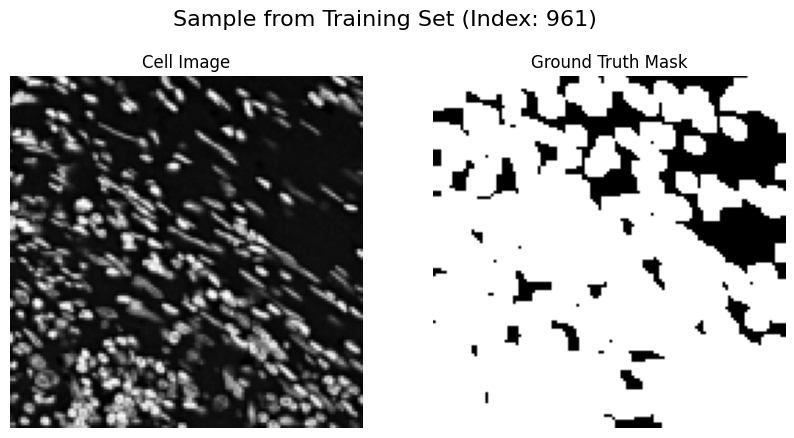


--- Validation Set Sample ---


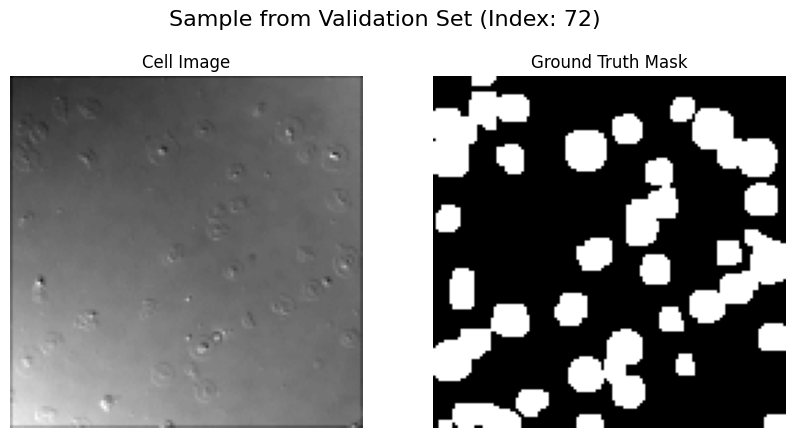

In [ ]:
# Step 5: Visualize Samples to Verify
# ====================================

import random

def display_sample(X, Y, dataset_name="Training"):
    """Displays a random sample image and its mask."""
    image_index = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'Sample from {dataset_name} Set (Index: {image_index})', fontsize=16)

    # Display the image
    ax[0].imshow(X[image_index].squeeze(), cmap='gray')
    ax[0].set_title('Cell Image')
    ax[0].axis('off')

    # Display the mask
    ax[1].imshow(Y[image_index].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    plt.show()

# Display one sample from the training set
print("--- Training Set Sample ---")
display_sample(X_train, Y_train, "Training")

# Display one sample from the validation set
print("\n--- Validation Set Sample ---")
display_sample(X_val, Y_val, "Validation")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection



def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv


def UNetCompiled(input_size=(128, 128, 1), n_filters=32, n_classes=2):
   """
   Combine both encoder and decoder blocks according to the U-Net research paper
   Return the model as output
   """
    # Input size represent the size of 1 image (the size used for pre-processing)
   inputs = Input(input_size)

   # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
   # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
   cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
   cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
   cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
   cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
   cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

   # Decoder includes multiple mini blocks with decreasing number of filters
   # Observe the skip connections from the encoder are given as input to the decoder
   # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
   ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
   ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
   ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
   ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)
   # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
   # Followed by a 1x1 Conv layer to get the image to the desired size.
   # Observe the number of channels will be equal to number of output classes
   conv9 = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(ublock9)
   conv10 = Conv2D(1, 1, activation="sigmoid", padding='same')(conv9)

   # Define the model
   model = tf.keras.Model(inputs=inputs, outputs=conv10)
   return model

In [ ]:
# Step 6: Define the U-Net Model Architecture
# ============================================
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation

# def unet_model_stable(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
#     inputs = Input(input_size)

#     # --- A stable convolutional block ---
#     def conv_block(input_tensor, num_filters):
#         x = Conv2D(num_filters, (3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
#         x = BatchNormalization()(x)
#         x = Activation('relu')(x)

#         x = Conv2D(num_filters, (3, 3), kernel_initializer='he_normal', padding='same')(x)
#         x = BatchNormalization()(x)
#         x = Activation('relu')(x)
#         return x

#     # --- Encoder (Contracting Path) ---
#     c1 = conv_block(inputs, 16)
#     p1 = MaxPooling2D((2, 2))(c1)

#     c2 = conv_block(p1, 32)
#     p2 = MaxPooling2D((2, 2))(c2)

#     c3 = conv_block(p2, 64)
#     p3 = MaxPooling2D((2, 2))(c3)

#     c4 = conv_block(p3, 128)
#     p4 = MaxPooling2D(pool_size=(2, 2))(c4)

#     # --- Bottleneck ---
#     c5 = conv_block(p4, 256)

#     # --- Decoder (Expanding Path) ---
#     def decoder_block(input_tensor, skip_tensor, num_filters):
#         x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
#         x = concatenate([x, skip_tensor])
#         x = conv_block(x, num_filters)
#         return x

#     d6 = decoder_block(c5, c4, 128)
#     d7 = decoder_block(d6, c3, 64)
#     d8 = decoder_block(d7, c2, 32)
#     d9 = decoder_block(d8, c1, 16)

#     # --- Output Layer ---
#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(d9)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model

# --- Instantiate the new, stable model ---
model = UNetCompiled()
model.summary()

# Step 7: Define Loss Function and Metrics
# ========================================
# For our metric, we will use MeanIoU.
# For our loss, we will use Binary Cross-Entropy, which is standard for
# binary classification problems (is this pixel a cell or not?).
# Adam is a robust, all-purpose optimizer.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop

# Dice Loss function
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Combined loss function
def total_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


model.compile(optimizer=Adam(learning_rate=1e-2),
              loss=total_loss,
              metrics=[MeanIoU(num_classes=2, name='mean_iou')])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 8,643,137 (32.97 MB)

 Trainable params: 8,641,153 (32.96 MB)

 Non-trainable params: 1,984 (7.75 KB)

--- Verifying Final Validation Data Alignment ---


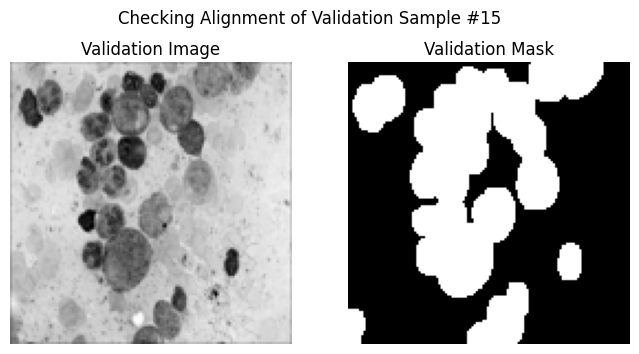


[INFO] The validation mask contains cell pixels as expected.
tf.data pipelines created successfully.
Preparing to overfit a single batch...
Attempting to overfit on one batch...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - loss: 1.5313 - mean_iou: 0.3749
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 1.2052 - mean_iou: 0.3138
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 1.1288 - mean_iou: 0.2866
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.9410 - mean_iou: 0.3329
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 1.5239 - mean_iou: 0.3895
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 1.2790 - mean_iou: 0.3506
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 1.0448 - mean_iou: 0.3125
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.9935 - mean_iou: 0.2440
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 1.0987 - mean_iou: 0.3359
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.8845 - mea

In [ ]:
## Final Sanity Check Before Training

print("--- Verifying Final Validation Data Alignment ---")

# Pick a specific sample to check (e.g., the 15th sample)
sample_index = 15

# Normalize the data first
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0

# Retrieve the image and mask from the FINAL arrays
# that you are about to pass to model.fit()
image_to_check = X_val_norm[sample_index]
mask_to_check = Y_val[sample_index]

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(f"Checking Alignment of Validation Sample #{sample_index}")

# Display the validation image
ax[0].imshow(image_to_check.squeeze(), cmap='gray')
ax[0].set_title("Validation Image")
ax[0].axis('off')

# Display the validation mask
ax[1].imshow(mask_to_check.squeeze(), cmap='gray')
ax[1].set_title("Validation Mask")
ax[1].axis('off')

plt.show()

# Check if the mask actually contains any white pixels (cells)
if np.max(mask_to_check) == 0:
    print("\n[CRITICAL PROBLEM] The validation mask is all black!")
else:
    print("\n[INFO] The validation mask contains cell pixels as expected.")


# --- Build the tf.data Pipelines ---
# This cell must be run before the sanity check



# Create TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train_norm, Y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_norm, Y_val))

# Set up the training pipeline
BATCH_SIZE = 16
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Set up the validation pipeline
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("tf.data pipelines created successfully.")

## --- ULTIMATE SANITY CHECK: OVERFIT ONE BATCH ---

print("Preparing to overfit a single batch...")

# 1. Get ONE batch from your training dataset pipeline
# This is exactly what the model would see in the first step of training
single_batch_ds = train_ds.take(1)

# 2. Re-instantiate your final, stable model to reset its weights
# Using the corrected 'unet_model_stable' or 'UNetCompiled'
# Make sure this is the model you intend to use
model = UNetCompiled(input_size=(128, 128, 1)) # Or unet_model_stable()

# 3. Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=total_loss,
              metrics=[MeanIoU(num_classes=2, name='mean_iou')])

# 4. Train the model on ONLY that single batch for many epochs
# We are not using any validation data for this test
print("Attempting to overfit on one batch...")
history_one_batch = model.fit(
    single_batch_ds,
    epochs=100, # Train for many epochs on the same tiny data
    verbose=1
)

--- Inspecting Final Training Data ---


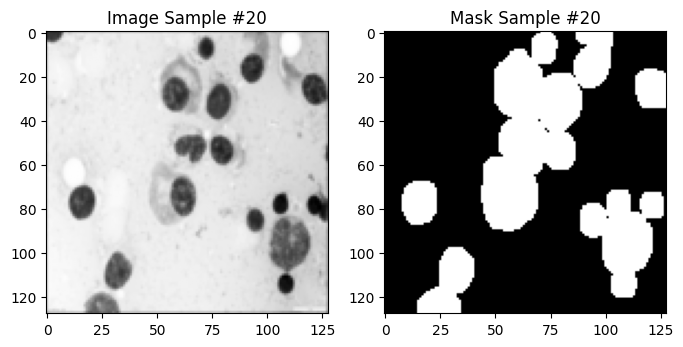


--- Properties of Full Datasets ---
--- X_train (Images) ---
Shape: (978, 128, 128, 1)
Data Type: uint8
Min Value: 0
Max Value: 255

--- Y_train (Masks) ---
Shape: (978, 128, 128, 1)
Data Type: bool
Min Value: False
Max Value: True
Unique Values: [False  True]

--- X_train_norm (Normalized Images) ---
Shape: (978, 128, 128, 1)
Data Type: float64
Min Value: 0.0
Max Value: 1.0


In [ ]:
## --- DEEP DATA INSPECTION ---

print("--- Inspecting Final Training Data ---")

# Check the arrays that are used to create the tf.data.Dataset
# This is after loading and before passing to the pipeline

# 1. Check a single image and mask
sample_index = 20 # Pick an index
image_sample = X_train_norm[sample_index]
mask_sample = Y_train[sample_index]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(image_sample.squeeze(), cmap='gray')
ax[0].set_title(f"Image Sample #{sample_index}")
ax[1].imshow(mask_sample.squeeze(), cmap='gray')
ax[1].set_title(f"Mask Sample #{sample_index}")
plt.show()

# 2. Print the properties of the ENTIRE dataset
print("\n--- Properties of Full Datasets ---")
print("--- X_train (Images) ---")
print(f"Shape: {X_train.shape}")
print(f"Data Type: {X_train.dtype}")
print(f"Min Value: {X_train.min()}")
print(f"Max Value: {X_train.max()}")

print("\n--- Y_train (Masks) ---")
print(f"Shape: {Y_train.shape}")
print(f"Data Type: {Y_train.dtype}")
print(f"Min Value: {Y_train.min()}")
print(f"Max Value: {Y_train.max()}")
print(f"Unique Values: {np.unique(Y_train)}")

# 3. Check the normalized image data
print("\n--- X_train_norm (Normalized Images) ---")
print(f"Shape: {X_train_norm.shape}")
print(f"Data Type: {X_train_norm.dtype}")
print(f"Min Value: {X_train_norm.min()}")
print(f"Max Value: {X_train_norm.max()}")

Instantiating the stable U-Net model...
Compiling model with standard BinaryCrossentropy...
Attempting to overfit a single batch of shape (16, 128, 128, 1)...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - loss: 0.8987 - mean_iou: 0.3469
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.7001 - mean_iou: 0.3469
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.5856 - mean_iou: 0.3469
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.4791 - mean_iou: 0.3469
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.4284 - mean_iou: 0.3469
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3597 - mean_iou: 0.3469
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3399 - mean_iou: 0.3469
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.3323 - mean_iou: 0.3469
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3073 - mean_iou: 0.3474
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.2843 - mean_iou: 0.3473
Epoc

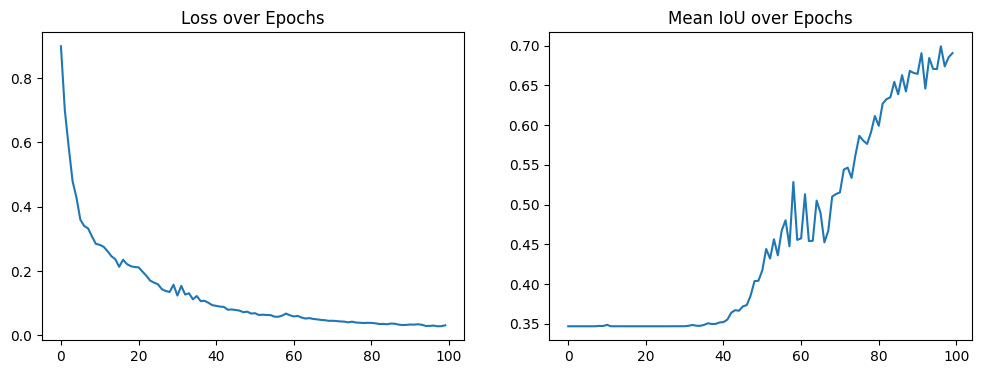

In [ ]:
## --- FINAL TEST: ABSOLUTE SIMPLIFICATION ---

# 1. Re-instantiate your final, stable model
# Make sure you are using the corrected model with Batch Norm
# and the Conv -> BN -> Activation order.
print("Instantiating the stable U-Net model...")
model = UNetCompiled(input_size=(128, 128, 1)) # Or your stable model function

# 2. Compile the model with the simplest possible loss
# We are REMOVING our custom total_loss for this test.
print("Compiling model with standard BinaryCrossentropy...")
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy', # Use the standard built-in loss
              metrics=[MeanIoU(num_classes=2, name='mean_iou')])

# 3. Get a single batch of data as numpy arrays
# We are NOT using the tf.data pipeline for this test.
X_batch = X_train_norm[0:16]
Y_batch = Y_train[0:16]

# 4. Attempt to overfit the single batch
print(f"Attempting to overfit a single batch of shape {X_batch.shape}...")
history = model.fit(
    X_batch,
    Y_batch,
    epochs=100,
    verbose=1
)

# 5. Plot the results of the overfitting test
import matplotlib.pyplot as plt

print("\n--- Overfitting Test Results ---")
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history.history['loss'])
ax[0].set_title('Loss over Epochs')
ax[1].plot(history.history['mean_iou'])
ax[1].set_title('Mean IoU over Epochs')
plt.show()

In [ ]:
# --- Final Training Run: Baseline ---

# 1. Instantiate the stable model
print("Instantiating the stable U-Net model...")
model = UNetCompiled(input_size=(128, 128, 1))

# 2. Compile with the simple, proven loss function
print("Compiling model with standard BinaryCrossentropy...")
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy', # Use the standard built-in loss
              metrics=[MeanIoU(num_classes=2, name='mean_iou')])

# 3. Make sure your full tf.data pipelines are defined
# (This includes the data augmentation step for the training set)
# train_ds = ...
# val_ds = ...

# 4. Define callbacks with appropriate patience
checkpoint = ModelCheckpoint('best_model_bce.h5', monitor='val_mean_iou', mode='max', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_mean_iou', mode='max', patience=15, verbose=1)

# 5. Train on the full dataset
print("Starting training on the full dataset...")
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping]
)

Instantiating the stable U-Net model...
Compiling model with standard BinaryCrossentropy...
Starting training on the full dataset...
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.5813 - mean_iou: 0.3064
Epoch 1: val_mean_iou improved from -inf to 0.27748, saving model to best_model_bce.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 603s 9s/step - loss: 0.5804 - mean_iou: 0.3064 - val_loss: 0.5948 - val_mean_iou: 0.2775
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.4341 - mean_iou: 0.3023
Epoch 2: val_mean_iou did not improve from 0.27748
62/62 ━━━━━━━━━━━━━━━━━━━━ 591s 10s/step - loss: 0.4339 - mean_iou: 0.3024 - val_loss: 0.6802 - val_mean_iou: 0.2775
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.4434 - mean_iou: 0.3101 
Epoch 3: val_mean_iou did not improve from 0.27748
62/62 ━━━━━━━━━━━━━━━━━━━━ 628s 10s/step - loss: 0.4431 - mean_iou: 0.3101 - val_loss: 0.5918 - val_mean_iou: 0.2775
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.4008 - mean_iou: 0.3083
Epoch 4: val_mean_iou did not improve from 0.27748
62/62 ━━━━━━━━━━━━━━━━━━━━ 617s 10s/step - loss: 0.4007 - mean_iou: 0.3083 - val_loss: 0.5299 - val_mean_iou: 0.2775
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.4030 - mean_iou: 0.3108
Epoch 5: val_mean_iou did not improve from 0.27

In [ ]:
# Load the best model from your last training run
model.load_weights('best_model_bce.h5')

# Make predictions on the validation set
preds_val = model.predict(X_val_norm, verbose=1)

# --- Find the Optimal Threshold ---
# Loop through different thresholds to see which one gives the best IoU
best_iou = 0
best_threshold = 0
iou_metric = MeanIoU(num_classes=2, name='mean_iou')

for threshold in np.arange(0.1, 0.9, 0.05):
    # Apply threshold
    preds_val_t = (preds_val > threshold).astype(np.uint8)

    # Update the IoU metric state
    iou_metric.update_state(Y_val, preds_val_t)

    # Calculate the IoU
    current_iou = iou_metric.result().numpy()

    # Reset the metric state for the next loop
    iou_metric.reset_state()

    print(f"Threshold: {threshold:.2f}, IoU: {current_iou:.4f}")

    if current_iou > best_iou:
        best_iou = current_iou
        best_threshold = threshold

print(f"\nBest IoU found: {best_iou:.4f} at threshold: {best_threshold:.2f}")

In [ ]:
# 1. Instantiate the stable model
model = UNetCompiled(input_size=(128, 128, 1))

# 2. Compile with the combined loss and a fine-tuning learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), # Use a slightly lower LR for fine-tuning
              loss=total_loss,
              metrics=[MeanIoU(num_classes=2, name='mean_iou')])

# 3. Increase patience to allow for longer, more stable training
checkpoint = ModelCheckpoint('best_model_final.h5', monitor='val_mean_iou', mode='max', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_mean_iou', mode='max', patience=20, verbose=1) # More patience

# 4. Train the model
history = model.fit(
    train_ds,
    epochs=100, # Give it plenty of time to learn
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping]
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Re-instantiate and compile the model ---
model = UNetCompiled(input_size=(128, 128, 1)) # Or your preferred stable model

model.compile(optimizer=Adam(learning_rate=1e-3), # Start with a higher learning rate
              loss=total_loss,
              metrics=[MeanIoU(num_classes=2, name='mean_iou')])


# --- Define Callbacks ---
# This callback will reduce the learning rate when the val_loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, # Reduce learning rate by a factor of 5
                              patience=5,  # Reduce if val_loss doesn't improve for 5 epochs
                              verbose=1)

# ModelCheckpoint should now monitor val_loss as well or keep monitoring val_mean_iou
checkpoint = ModelCheckpoint('best_model_final.h5', monitor='val_mean_iou', mode='max', save_best_only=True, verbose=1)

# EarlyStopping should have a higher patience
early_stopping = EarlyStopping(monitor='val_mean_iou', mode='max', patience=20, verbose=1)


# --- Train the model ---
print("\nStarting model training with Learning Rate Scheduler...")

history = model.fit(
    train_ds,
    epochs=100, # Give it plenty of time to learn
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping, reduce_lr] # Add the new callback
)

In [ ]:
# Step 8: Define Callbacks and Train the Model
# ============================================
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
# Save the best model based on validation IoU
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_mean_iou',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Stop training if validation IoU doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_mean_iou',
                               mode='max',
                               patience=5,
                               verbose=1)

# --- Start Training ---
# We are feeding the training data (X_train, Y_train) and using the
# tuning data (X_val, Y_val) for validation.
print("\nStarting model training...")

# Normalize image data to the [0, 1] range for better training performance
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0

history = model.fit(X_train_norm, Y_train,
                    batch_size=16,
                    epochs=50, # Set a high number, EarlyStopping will find the best epoch
                    validation_data=(X_val_norm, Y_val),
                    callbacks=[checkpoint, early_stopping])

print("\nModel training complete.")

In [ ]:
# Step 9: Evaluate Model Performance Quantitatively
# =================================================
# Plot the training and validation loss and IoU

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation loss values
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation Mean IoU values
ax[1].plot(history.history['mean_iou'])
ax[1].plot(history.history['val_mean_iou'])
ax[1].set_title('Model Mean IoU')
ax[1].set_ylabel('Mean IoU')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='lower right')

plt.show()

# Step 10: Evaluate Model Performance Qualitatively
# ==================================================
# Load the best model that was saved during training
model.load_weights('best_model.h5')

# Make predictions on the validation set
preds_val = model.predict(X_val_norm, verbose=1)

# Threshold the predictions to get a binary mask (0 or 1)
# The model outputs probabilities, so we set a threshold of 0.5.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Visualize some predictions
def display_predictions(X, Y_true, Y_pred, dataset_name="Validation"):
    """Displays the original image, true mask, and predicted mask."""
    # Pick a random sample
    image_index = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Prediction Sample from {dataset_name} Set (Index: {image_index})', fontsize=16)

    # Display original image (from the non-normalized validation set)
    ax[0].imshow(X[image_index].squeeze(), cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Display ground truth mask
    ax[1].imshow(Y_true[image_index].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Display predicted mask
    ax[2].imshow(Y_pred[image_index].squeeze(), cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    plt.show()

# Show a few random prediction samples
print("\n--- Displaying Prediction Samples ---")
for i in range(3):
    display_predictions(X_val, Y_val, preds_val_t)